<h1 align="center"><font></font>Prédiction d'un cross-selling en assurance</h1>

- Analyse exploratoire
- Feature engineering
- Sélection du modèle
- Modele Agnostic

In [5]:
# Importation des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.stats.mstats import winsorize
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import  LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

import warnings
warnings.filterwarnings("ignore", ".*do not.*",)

# **Analyse exploratoire**

## Importation des données   

In [6]:
# Nous subdiviserons la base de donnée en deux sous bases
# d'entrainement et de validation. 80% des données seront 
# des données d'entrainement et 15% des données de test.
# Dans la suite, nous subidiviserons la base de donnée 
# d'entrainement en base d'entrainement et de validation 
# L'argument shuffle permet d'effectuer l'échantillonnage 
# sur une base probabiliste.  
# Nous utilisons np.random.seed(1234) afin d'assurer la 
# reproductibilité de nos résultats. 
train_set = pd.read_csv("./files/groupe_2_train.csv")

## Exploration des données

### Data Understanding

In [3]:
# Affichage des dimensions du 
# dataset
train_set.shape

(84027, 11)

In [4]:
# Affichage de quelques observations
# de la base de donnée d'entraînement
train_set.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Female,23,1,29,1,< 1 Year,No,36839,152,43,0
1,Male,22,1,15,1,< 1 Year,No,50566,152,294,0
2,Male,46,1,7,1,1-2 Year,No,2630,26,199,0
3,Male,32,1,28,0,< 1 Year,Yes,31255,152,229,0
4,Female,27,1,41,1,< 1 Year,No,30722,152,113,0


In [5]:
# Overview sur les types de variable
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84027 entries, 0 to 84026
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Gender                84027 non-null  object
 1   Age                   84027 non-null  int64 
 2   Driving_License       84027 non-null  int64 
 3   Region_Code           84027 non-null  int64 
 4   Previously_Insured    84027 non-null  int64 
 5   Vehicle_Age           84027 non-null  object
 6   Vehicle_Damage        84027 non-null  object
 7   Annual_Premium        84027 non-null  int64 
 8   Policy_Sales_Channel  84027 non-null  int64 
 9   Vintage               84027 non-null  int64 
 10  Response              84027 non-null  int64 
dtypes: int64(8), object(3)
memory usage: 7.1+ MB


In [6]:
# Description sommaire des variables
# qualitatives de la base
train_set.describe(include="O")

,Gender,Vehicle_Age,Vehicle_Damage
count,84027,84027,84027
unique,2,3,2
top,Male,1-2 Year,Yes
freq,46316,46992,48704


In [7]:
# Description sommaire des variables
# quantitatives de la base
train_set.describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,84027.000000,84027.000000,84027.000000,84027.000000,84027.000000,84027.000000,84027.000000,84027.000000
mean,40.141669,0.997917,26.441608,0.386697,30749.681388,109.203994,168.643567,0.257858
std,16.443320,0.045589,13.030719,0.486996,17633.575685,54.872813,213.169257,0.437458
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24433.000000,26.000000,82.000000,0.000000
50%,39.000000,1.000000,28.000000,0.000000,31856.000000,124.000000,154.000000,0.000000
75%,50.000000,1.000000,35.000000,1.000000,39738.000000,152.000000,228.000000,1.000000
max,157.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,5980.000000,1.000000


### Data Cleaning

In [8]:
# Détermination des doublons de 
# la base de donnée d'entrainement
train_set[train_set.duplicated(keep="first")]

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
26691,Male,34,1,12,0,1-2 Year,Yes,2630,157,284,1
43392,Male,43,1,28,0,1-2 Year,Yes,2630,26,299,0
47968,Female,36,1,28,0,1-2 Year,Yes,2630,124,145,1
50010,Female,38,1,13,0,1-2 Year,Yes,2630,124,220,1
55728,Male,40,1,35,0,1-2 Year,Yes,2630,124,194,0
56055,Male,43,1,15,0,1-2 Year,Yes,2630,124,262,1
61217,Female,24,1,27,0,< 1 Year,Yes,2630,152,213,0
62508,Female,42,1,28,0,1-2 Year,Yes,2630,26,150,1
73146,Female,26,1,29,1,< 1 Year,No,2630,152,56,0
73174,Female,44,1,28,0,1-2 Year,Yes,2630,26,89,1


In [9]:
# Suppression des doublons de la base de données
# Nous spécifions de ne retenir que la première
# observation en cas de doublons.
train_set.drop_duplicates(keep="first", inplace=True)

### Data Visualization

#### Analyse univariée

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


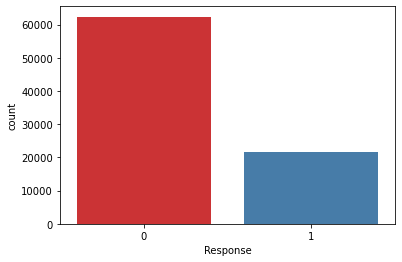

In [10]:
# Analyse univariée de la variable d'intérêt.
sns.countplot("Response", data=train_set, palette="Set1")
plt.show()

In [11]:
# On remarque qu'il y'a une faible proportion
# d'individus intéressés par l'assurance auto
# par rapport aux individus non-intéressés.
# La distribution selon le genre de la base
# n'est pas très inégalement répartie

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


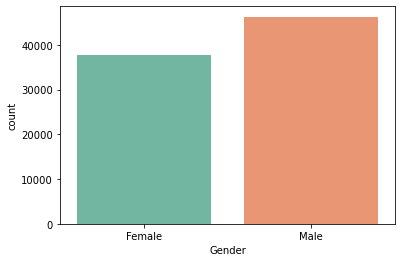

In [12]:
# Analyse univariée de la variable Gender.
sns.countplot("Gender", data=train_set, palette="Set2")
plt.show()
# Ainsi, la base de donnée est largement dominée par les individus 
# ayant des véhicules d'age inférieur à 2 ans.

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


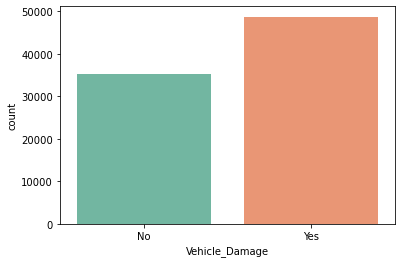

In [13]:
# Analyse univariée de la variable vehicle_Damage.
sns.countplot("Vehicle_Damage", data=train_set, palette="Set2")
plt.show()
# Ainsi, la base de donnée est largement dominée par les individus 
# ayant des véhicules d'age inférieur à 2 ans.

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


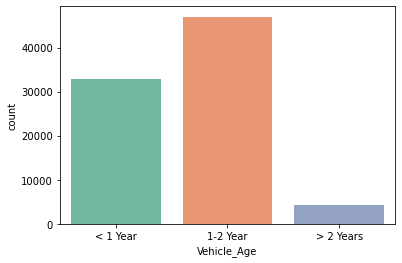

In [14]:
# Analyse univariée de la variable vehicle_Age.
sns.countplot("Vehicle_Age", data=train_set, palette="Set2")
plt.show()
# Ainsi, la base de donnée est largement dominée par les individus 
# ayant des véhicules d'age inférieur à 2 ans.

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


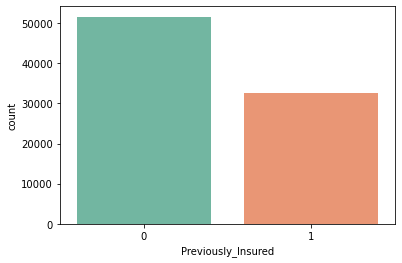

In [15]:
# Analyse univariée de la variable Previously_Insured
sns.countplot("Previously_Insured", data=train_set, palette="Set2")
plt.show()
# Ainsi, dans la base il y a plus d'individus sans assurance que
# d'individus déja assurés

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


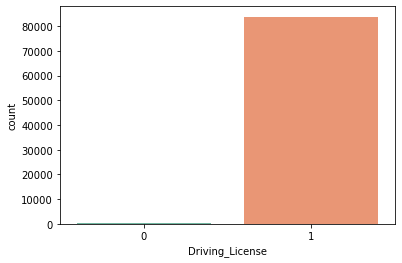

In [16]:
# Analyse univariée de la variable Driving_License.
sns.countplot("Driving_License", data=train_set, palette="Set2")
plt.show()
# On en déduit qu'il n'y a quasiment pas individu sans permis de conduire 
# dans la base de donnée.

In [17]:
## Affichage des individus n'ayant pas de permis
## dans la base de donnée
len(train_set[train_set.Driving_License==0])/len(train_set)
## Par suite, il existe seulement 175/84027 individus
## dans la base de donnée n'ayant pas de permis de 
## conduire, ce qui represente 0,2% de la polpulation
## totale.

0.002082936583507903

<AxesSubplot:>

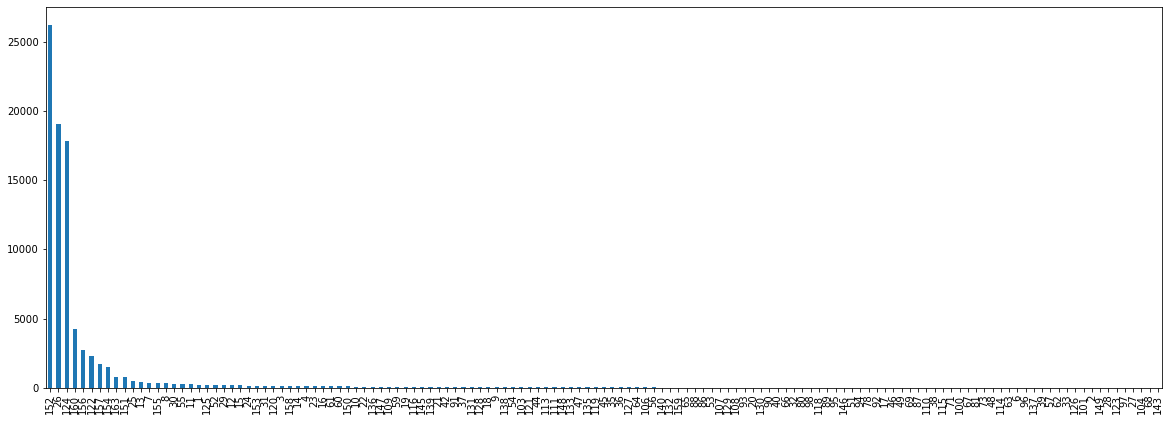

In [18]:
# Analyse univariée de la variable Policy Sales Channel.
sales = train_set["Policy_Sales_Channel"].value_counts()
sales.plot(kind="bar", figsize=(20, 7))

In [19]:

train_set1 = train_set["Policy_Sales_Channel"]\
    .apply(lambda x: 999 if x in sales[10:].index else x)

In [20]:
sales[10:].sum()/sales.sum()

0.08228194629594363

<AxesSubplot:>

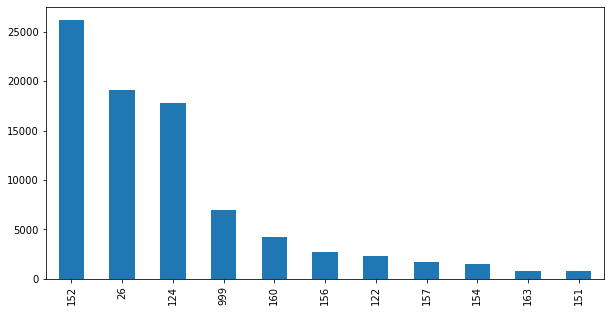

In [21]:
sales1 = train_set1.value_counts()
sales1.plot(kind="bar", figsize=(10, 5))

<AxesSubplot:>

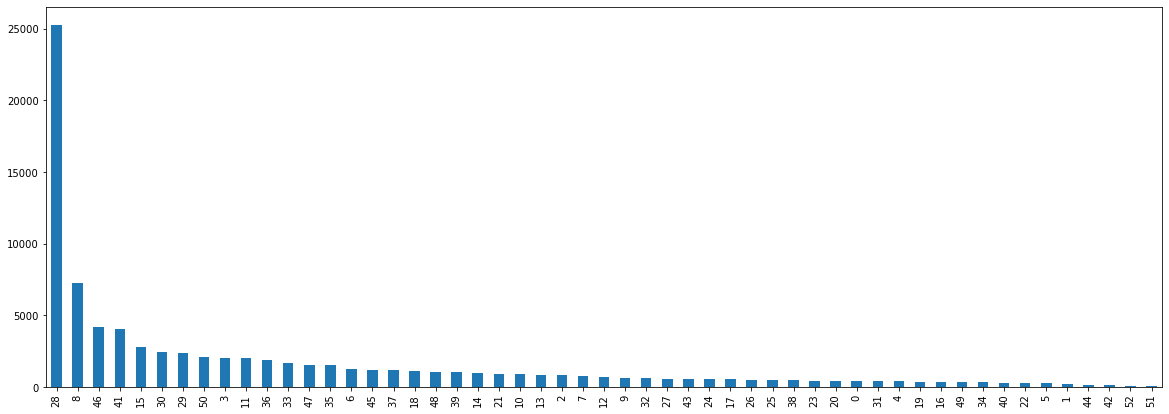

In [22]:
# Analyse univariée de la variable Policy Sales Channel.
region = train_set["Region_Code"].value_counts()
region.plot(kind="bar", figsize=(20, 7))

In [23]:
region[30:].sum()/region.sum()

0.09825509426775852

In [24]:
train_set2 = train_set["Region_Code"]\
    .apply(lambda x: 888 if x in region[30:].index else x)

<AxesSubplot:>

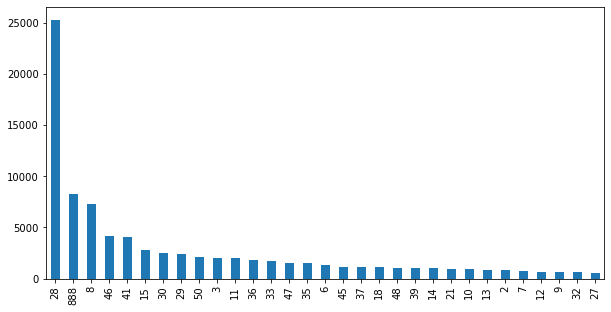

In [25]:
region1 = train_set2.value_counts()
region1.plot(kind="bar", figsize=(10, 5))

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


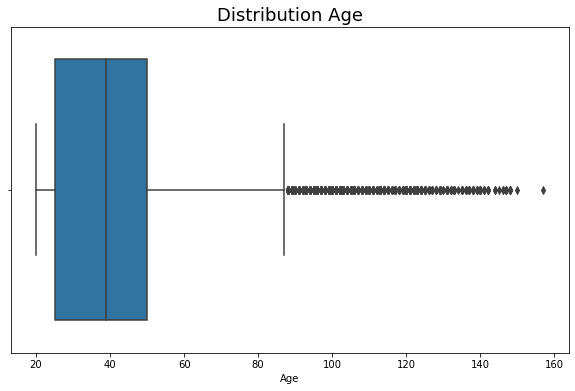

In [26]:
# Analyse univariée de la variable Age
plt.figure(figsize = (10,6))
sns.boxplot(train_set.Age)
plt.title('Distribution Age',size=18)
plt.show()

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


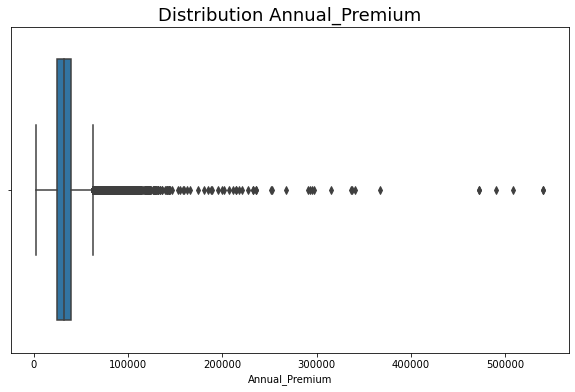

In [27]:
# Analyse univariée de la variable Annual_Premium
plt.figure(figsize = (10,6))
sns.boxplot(train_set.Annual_Premium)
plt.title('Distribution Annual_Premium',size=18)
plt.show()

/home/koffie/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


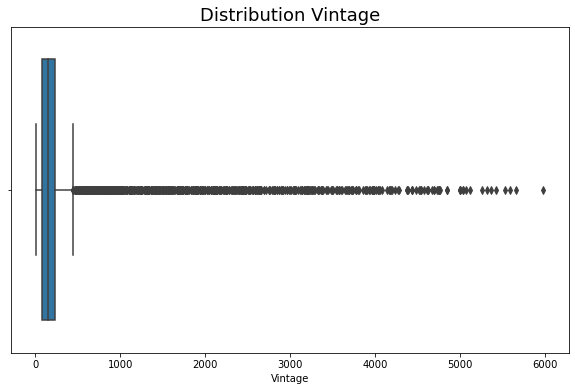

In [28]:
# Analyse univariée de la variable Vintage
plt.figure(figsize = (10,6))
sns.boxplot(train_set.Vintage)
plt.title('Distribution Vintage',size=18)
plt.show()

#### Analyse multivariée

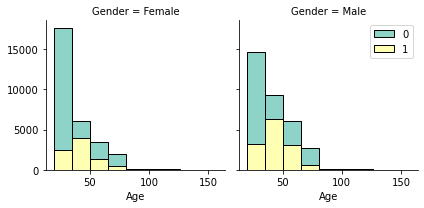

In [29]:
# Analyse trivariée de la variable reponse en fonction de l'age
# et du genre.
bins = np.linspace(train_set.Age.min(), train_set.Age.max(), 10)
g = sns.FacetGrid(train_set, col="Gender", hue="Response", palette="Set3", col_wrap=2)
g.map(plt.hist, 'Age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

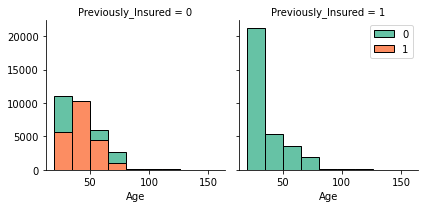

In [30]:
# Analyse trivariée de la variable réponse en fonction de l'age
# et de Previously_Insured
g = sns.FacetGrid(train_set, col="Previously_Insured", hue="Response", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

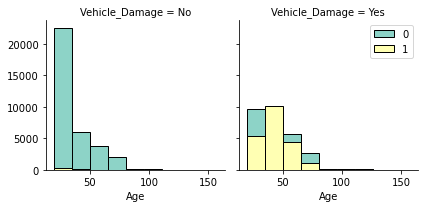

In [31]:
# Analyse trivariée de la variable réponse en fonction de l'age
# et de la variable Vehicle_Damage.
g = sns.FacetGrid(train_set, col="Vehicle_Damage", hue="Response", palette="Set3", col_wrap=2)
g.map(plt.hist, 'Age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

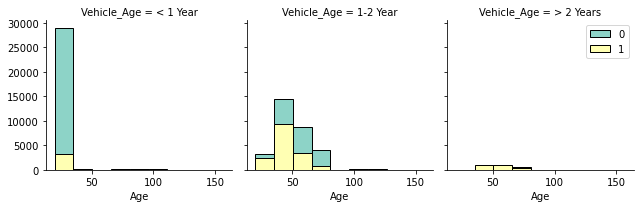

In [32]:
# Analyse trivariée de la variable réponse en fonction de 
# l'age et de la variable Vehicle_Age.
bins = np.linspace(train_set.Age.min(), train_set.Age.max(), 10)
g = sns.FacetGrid(train_set, col="Vehicle_Age", hue="Response", palette="Set3", col_wrap=3)
g.map(plt.hist, 'Age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

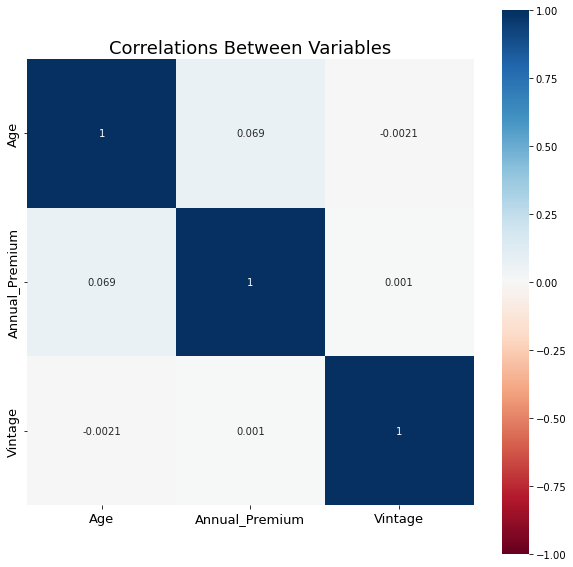

In [33]:
# Analyse de la corrélation entre les différentes
# variables quantitatives ainsi qu'avec la variable
# d'intérêt
var_quants = ["Age", "Annual_Premium", "Vintage"]
plt.figure(figsize = (10,10))
sns.heatmap(train_set[var_quants].corr(),annot=True,square=True,
            cmap='RdBu',
            vmax=1,
            vmin=-1)
plt.title('Correlations Between Variables',size=18);
plt.xticks(size=13)
plt.yticks(size=13)
plt.show()

In [8]:
var_quant = ["Age", "Annual_Premium", "Vintage", "Response"]
sns.pairplot(train_set[var_quant], hue="Response", kind="reg")

### Data Preprocessing

In [35]:
## duplication de la base de donnée train
train = train_set.copy()

In [36]:
## Recodage de la variable Policy_Sales_Channel
## Nous choisissons de regrouper tous les cannaux
## faiblement representés ensemble.
sales = train["Policy_Sales_Channel"].value_counts()
train["Policy_Sales_Channel"] = train["Policy_Sales_Channel"]\
    .apply(lambda x: 999 if x in sales[10:].index else x)

In [37]:
## Recodage de la variable Region_Code
## Nous choisissons encore de regrouper toutes
## les régions faiblement représentée  ensemble.
region = train["Region_Code"].value_counts()
train["Region_Code"] = train["Region_Code"]\
    .apply(lambda x: 888 if x in region[30:].index else x)

In [38]:
## Recodage des variables Gender
train["Gender"] = train["Gender"].replace({"Male":1, "Female":0})
train["Vehicle_Damage"] = train["Vehicle_Damage"].replace({"Yes":1, "No":0})

In [39]:
## One hot encoding sur les variables
## catégorielles 
train= train.astype({"Region_Code":str})
train = train.astype({"Policy_Sales_Channel": str})
train = train.astype({"Vehicle_Age": str})
train = pd.get_dummies(train)
train = train.rename({"Vehicle_Age_< 1 Year": "Vehicle_Age_Inf 1 Year", 
                      "Vehicle_Age_> 2 Years" : "Vehicle_Age_Sup 2 Years"}, 
                      axis=1)

In [40]:
## Traitement des outliers par winsorization
train[var_quants] = train[var_quants].apply(lambda x: winsorize(x, limits=[.01, .028]))

In [41]:
## Standardisation de la base de donnée 
for var in var_quants:
    scale = StandardScaler()
    train[var] = scale.fit_transform(train[[var]]) 

#### Feature Selection

In [43]:
x_train, x_test, y_train, y_test = train_test_split(train.drop("Response",axis=1),
                                                    train["Response"],
                                                    train_size=.8,
                                                    shuffle=True)

##### Training Without feature selection

In [122]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [123]:
score = {}
## Training logistic Regression
model_log = LogisticRegression()
model_log.fit(x_train, y_train)
acc = f1_score(model_log.predict(x_test), y_test)
score["log"] = [acc,]
print("logistic finished")

## Training RandomForest
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)
acc = f1_score(model_rf.predict(x_test), y_test)
score["rf"] = [acc,]
print("randomForest finished")


## Training XGBoost
model_xgb = xgb.XGBClassifier()
model_xgb.fit(x_train, y_train)
acc = f1_score(model_xgb.predict(x_test), y_test)
score["xgb"] = [acc,]
print("xgboost finished")

## Training LightGBM
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(x_train, y_train)
acc = f1_score(model_lgb.predict(x_test), y_test)
score["lgb"] = [acc,]
print("lightgbm finished")

/home/koffie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic finished
randomForest finished
xgboost finished
lightgbm finished


<Figure size 360x360 with 0 Axes>

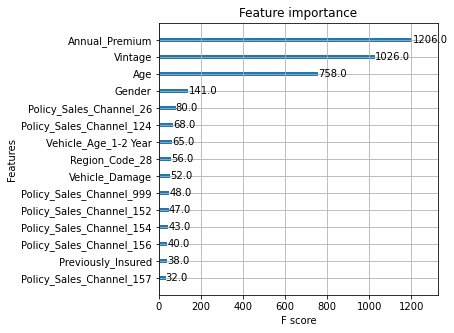

<Figure size 360x360 with 0 Axes>

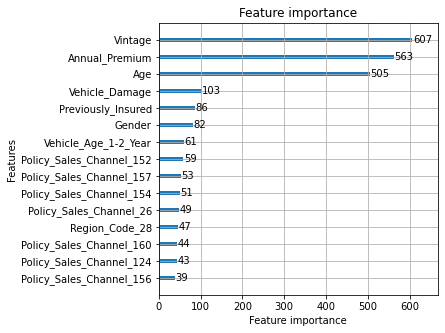

In [124]:
## Plotting feature importance based on Xgboost
## and LightGBM
plt.figure(figsize=(5,5))
xgb.plot_importance(model_xgb, max_num_features=15)
plt.rcParams["figure.figsize"] = (5,5)

plt.figure(figsize=(5,5))
lgb.plot_importance(model_lgb, max_num_features=15)
plt.rcParams["figure.figsize"] = (5,5)
plt.show()

##### Training with feature selection


In [131]:
## La feature importance réalisée sur les modèles
## de Random Forest  de Xgboost et de regression
## logistique nous fournit les variables les plus
## importantes suivantes : 
selected_features = ["Age", "Annual_Premium", "Vintage",
                     "Gender", "Policy_Sales_Channel_26",
                     "Vehicle_Damage", "Policy_Sales_Channel_124",
                     "Region_Code_28", "Vehicle_Age_1-2 Year",
                     "Policy_Sales_Channel_152", "Region_Code_8",
                     "Policy_Sales_Channel_999", "Policy_Sales_Channel_157",
                     "Policy_Sales_Channel_154", "Policy_Sales_Channel_156",
                     "Region_Code_46", "Previously_Insured","Vehicle_Age_Sup 2 Years",
                     "Policy_Sales_Channel_160", "Region_Code_888", "Response"]

train1 = train[selected_features]
x_train, x_test, y_train, y_test = train_test_split(train1.drop("Response",axis=1),
                                                    train1["Response"],
                                                    train_size=.8,
                                                    shuffle=True)


In [132]:
## Training logistic Regression
model_log = LogisticRegression()
model_log.fit(x_train, y_train)
acc = f1_score(model_log.predict(x_test), y_test)
score["log"].append(acc)
print("logistic finished")

## Training RandomForest
model_rf = RandomForestClassifier()
model_rf.fit(x_train, y_train)
acc = f1_score(model_rf.predict(x_test), y_test)
score["rf"].append(acc)
print("randomForest finished")


## Training XGBoost
model_xgb = xgb.XGBClassifier()
model_xgb.fit(x_train, y_train)
acc = f1_score(model_xgb.predict(x_test), y_test)
score["xgb"].append(acc)
print("xgboost finished")

## Training LightGBM
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(x_train, y_train)
acc = f1_score(model_lgb.predict(x_test), y_test)
score["lgb"].append(acc)
print("lightgbm finished")

logistic finished
randomForest finished
xgboost finished
lightgbm finished


In [133]:
score_df = pd.DataFrame()
score_df["Model"] = pd.DataFrame(["logistic", "RF", "XGB", "LGB"])
score_df["without_FS"] = pd.DataFrame([i[0] for j, i in score.items()])
score_df["with_FS"] = pd.DataFrame([i[2] for j, i in score.items()])
score_df.set_index("Model", inplace=True)

<AxesSubplot:xlabel='Model'>

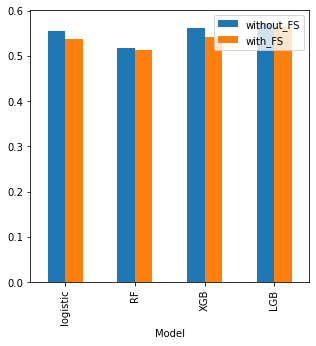

In [135]:
score_df.plot(kind="bar")

In [10]:
def preprocessing_df(train):
    """
    Fonction permettant de faire le
    préprocessing d'une base de donnée
    en respectant toutes les étapes déjà
    réalisées
    """

    base_data = pd.read_csv("./files/groupe_2_train.csv")
    ## Regroupement des variables Region_Code
    ## et Policy_Sales_Channel
    sales = train["Policy_Sales_Channel"].value_counts()
    train["Policy_Sales_Channel"] = train["Policy_Sales_Channel"]\
        .apply(lambda x: 999 if x in sales[10:].index else x)
    
    region = train["Region_Code"].value_counts()
    train["Region_Code"] = train["Region_Code"]\
        .apply(lambda x: 888 if x in region[30:].index else x)
    
    ## Recodage de la variable Gender et Vehicle_Damage
    train["Gender"] = train["Gender"].replace({"Male":1, "Female":0})
    train["Vehicle_Damage"] = train["Vehicle_Damage"].replace({"Yes":1, "No":0})

    ## One Hot Encoding des variables Vehicle_Age
    ## Policy_Sales_Channel et Region_Code
    train= train.astype({"Region_Code":str})
    train = train.astype({"Policy_Sales_Channel": str})
    train = train.astype({"Vehicle_Age": str})
    train = pd.get_dummies(train)
    train = train.rename({"Vehicle_Age_< 1 Year": "Vehicle_Age_Inf 1 Year", 
                          "Vehicle_Age_> 2 Years" : "Vehicle_Age_Sup 2 Years"}, 
                          axis=1)
    
    ## Traitement des outliers par winsorization
    var_quants = ["Age", "Annual_Premium", "Vintage"]
    train[var_quants] = train[var_quants]\
        .apply(lambda x: winsorize(x, limits=[.01, .02]))

    ## Standardisation des variables quantitatives
    scale1, scale2, scale3 = StandardScaler().fit(base_data[["Age"]]),\
                             StandardScaler().fit(base_data[["Annual_Premium"]]),\
                             StandardScaler().fit(base_data[["Vintage"]])
    
    train["Age"] = scale1.transform(train[["Age"]])
    train["Annual_Premium"] = scale2.transform(train[["Annual_Premium"]])
    train["Vintage"] = scale3.transform(train[["Vintage"]]) 

    ## Réalisation de la feature selection
    selected_features = ["Age", "Annual_Premium", "Vintage",
                     "Gender", "Policy_Sales_Channel_26",
                     "Vehicle_Damage", "Policy_Sales_Channel_124",
                     "Region_Code_28", "Vehicle_Age_1-2 Year",
                     "Policy_Sales_Channel_152", "Region_Code_8",
                     "Policy_Sales_Channel_999", "Policy_Sales_Channel_157",
                     "Policy_Sales_Channel_154", "Policy_Sales_Channel_156",
                     "Region_Code_46", "Previously_Insured","Vehicle_Age_Sup 2 Years",
                     "Policy_Sales_Channel_160", "Region_Code_888", "Response"]
    
    train = train[selected_features]
    
    return train

### Model Selection

#### Choix du modèle

In [11]:
## Importation de la base de donnée
tuning = preprocessing_df(train_set)
features = tuning.drop("Response", axis=1)
target = tuning["Response"]

In [115]:
n_splits = 20
smote = SMOTE()
folds = StratifiedKFold(n_splits=n_splits, shuffle=True)
folds = list(folds.split(tuning.drop("Response", axis=1), tuning["Response"]))

In [116]:
score_log = {}
score_log["log"] = []
score_log["xgb"] = []
score_log["rf"] = []
score_log["lgb"] = [] 
compt = 1
model_log = LogisticRegression()
model_xgb = xgb.XGBClassifier()
model_rf = RandomForestClassifier()
model_lgb = lgb.LGBMClassifier()
for train, test in folds:
    print(f"{compt} debut")

    target_train, target_test = target.iloc[train], target.iloc[test]
    features_train, features_test = features.iloc[train], features.iloc[test]

    features_train, target_train = smote.fit_resample(features_train, target_train)
    
    model_log.fit(features_train, target_train)
    print("log fin")
    model_xgb.fit(features_train, target_train)
    print("xgb fin")
    model_rf.fit(features_train, target_train)
    print("rf fin")
    model_lgb.fit(features_train, target_train)
    print("lgb fin")
    
    forecast_log1 = model_log.predict(features_test,)
    forecast_log2 = model_xgb.predict(features_test,)
    forecast_log3 = model_rf.predict(features_test,)
    forecast_log4 = model_lgb.predict(features_test,)
    score_log["log"].append(f1_score(target_test, forecast_log1))
    score_log["xgb"].append(f1_score(target_test, forecast_log2))
    score_log["rf"].append(f1_score(target_test, forecast_log3))
    score_log["lgb"].append(f1_score(target_test, forecast_log4))
    compt += 1
    print(f"{compt} fin")

NameError: name 'xgb' is not defined

In [323]:
score_df2 = pd.DataFrame()
for key, value in score_log.items():
    score_df2[key] = pd.DataFrame(value)
score_df2["fold"] = pd.DataFrame(range(1,21))
score_df2.set_index("fold", inplace=True)

<AxesSubplot:>

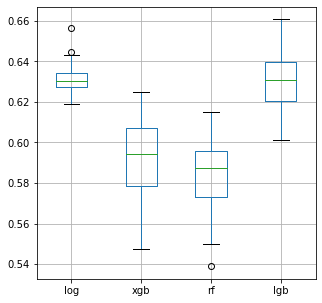

In [324]:
score_df2.boxplot()

### Tuning des modèles retenus

##### Tuning Logistic Regression

In [14]:
tuning_df = preprocessing_df(train_set)
tuning_df = tuning_df.sample(21000)

In [15]:
x_train, x_test, y_train, y_test=train_test_split(tuning_df.drop("Response",axis=1),
                                                  tuning_df["Response"], shuffle=True)
smote = SMOTE()
x_train, y_train = smote.fit_resample(x_train, y_train)

In [62]:
log_params = {
    "penalty": ["l1", "l2"],
    "C": np.logspace(-3, 3, 7),
    "solver": ["newton-cg", "lbfgs", "liblinear"]
}
model_log = LogisticRegression()
grid_search = GridSearchCV(model_log, log_params,
                           scoring = "f1", cv=10)

In [63]:
grid_search.fit(x_train, y_train)

/home/koffie/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
140 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
70 fits failed with the following error:
Traceback (most recent call last):
  File "/home/koffie/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/koffie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/koffie/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 61, in _check_

GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring='f1')

In [120]:
## Par suite les meilleurs paramètres de
## la log regression sont :
best_log = {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

In [122]:
## Comparaison du modèle avec tuning et
## du modèle de base
model_log0 = LogisticRegression()
model_log1 = LogisticRegression(**best_log)

score_log = {}
score_log["log0"] = []
score_log["log1"] = []
compt = 1
for train, test in folds:
    print(f"{compt} debut")

    target_train, target_test = target.iloc[train], target.iloc[test]
    features_train, features_test = features.iloc[train], features.iloc[test]

    features_train, target_train = smote.fit_resample(features_train, target_train)
    
    model_log0.fit(features_train, target_train)
    print("log0 fin")
    model_log1.fit(features_train, target_train)
    print("log1 fin")
    
    forecast_log1 = model_log0.predict(features_test,)
    forecast_log2 = model_log1.predict(features_test,)
    score_log["log0"].append(f1_score(target_test, forecast_log1))
    score_log["log1"].append(f1_score(target_test, forecast_log2))
    compt += 1
    print(f"{compt} fin")

1 debut
log0 fin
log1 fin
2 fin
2 debut
log0 fin
log1 fin
3 fin
3 debut
log0 fin
log1 fin
4 fin
4 debut
log0 fin
log1 fin
5 fin
5 debut
log0 fin
log1 fin
6 fin
6 debut
log0 fin
log1 fin
7 fin
7 debut
log0 fin
log1 fin
8 fin
8 debut
log0 fin
log1 fin
9 fin
9 debut
log0 fin
log1 fin
10 fin
10 debut
log0 fin
log1 fin
11 fin
11 debut
log0 fin
log1 fin
12 fin
12 debut
log0 fin
log1 fin
13 fin
13 debut
log0 fin
log1 fin
14 fin
14 debut
log0 fin
log1 fin
15 fin
15 debut
log0 fin
log1 fin
16 fin
16 debut
log0 fin
log1 fin
17 fin
17 debut
log0 fin
log1 fin
18 fin
18 debut
log0 fin
log1 fin
19 fin
19 debut
log0 fin
log1 fin
20 fin
20 debut
log0 fin
log1 fin
21 fin


<AxesSubplot:>

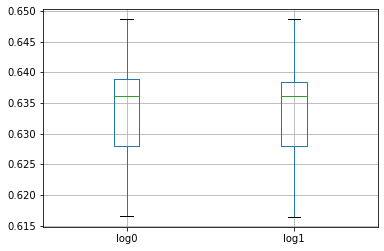

In [125]:
score_df2 = pd.DataFrame()
for key, value in score_log.items():
    score_df2[key] = pd.DataFrame(value)
score_df2["fold"] = pd.DataFrame(range(1,21))
score_df2.set_index("fold", inplace=True)
score_df2.boxplot()

##### Tuning Light Gradient Boosting

In [105]:
lgbm_params = {
    "n_estimators": [15],
    "colsample_bytree": [.5],
    "max_depth": [20],
    "num_leaves": [400],
    "min_split_gain":[.4],
}
model_lgb = lgb.LGBMClassifier()
grid_lgb = GridSearchCV(model_lgb, lgbm_params,
                        scoring="f1", cv=3, verbose=True)

In [106]:
grid_lgb.fit(x_train, y_train)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'colsample_bytree': [0.5], 'max_depth': [20],
                         'min_split_gain': [0.4], 'n_estimators': [15, 16],
                         'num_leaves': [400]},
             scoring='f1', verbose=True)

In [104]:
grid_lgb.best_params_

{'colsample_bytree': 0.5,
 'max_depth': 20,
 'min_split_gain': 0.4,
 'n_estimators': 15,
 'num_leaves': 400}

In [126]:
best_lgb = {'colsample_bytree': 0.5,
 'max_depth': 20,
 'min_split_gain': 0.4,
 'n_estimators': 15,
 'num_leaves': 400}

In [128]:
## Comparaison du modèle retenu au 
## modèle sans tuning
## Comparaison du modèle avec tuning et
## du modèle de base
model_lgb0 = lgb.LGBMClassifier()
model_lgb1 = lgb.LGBMClassifier(**best_lgb)

score_log = {}
score_log["lgb0"] = []
score_log["lgb1"] = []
compt = 1
for train, test in folds:
    print(f"{compt} debut")

    target_train, target_test = target.iloc[train], target.iloc[test]
    features_train, features_test = features.iloc[train], features.iloc[test]

    features_train, target_train = smote.fit_resample(features_train, target_train)
    
    model_lgb0.fit(features_train, target_train)
    print("lgb0 fin")
    model_lgb1.fit(features_train, target_train)
    print("lgb1 fin")
    
    forecast_log1 = model_lgb0.predict(features_test,)
    forecast_log2 = model_lgb1.predict(features_test,)
    score_log["lgb0"].append(f1_score(target_test, forecast_log1))
    score_log["lgb1"].append(f1_score(target_test, forecast_log2))
    compt += 1
    print(f"{compt} fin")

1 debut
lgb0 fin
lgb1 fin
2 fin
2 debut
lgb0 fin
lgb1 fin
3 fin
3 debut
lgb0 fin
lgb1 fin
4 fin
4 debut
lgb0 fin
lgb1 fin
5 fin
5 debut
lgb0 fin
lgb1 fin
6 fin
6 debut
lgb0 fin
lgb1 fin
7 fin
7 debut
lgb0 fin
lgb1 fin
8 fin
8 debut
lgb0 fin
lgb1 fin
9 fin
9 debut
lgb0 fin
lgb1 fin
10 fin
10 debut
lgb0 fin
lgb1 fin
11 fin
11 debut
lgb0 fin
lgb1 fin
12 fin
12 debut
lgb0 fin
lgb1 fin
13 fin
13 debut
lgb0 fin
lgb1 fin
14 fin
14 debut
lgb0 fin
lgb1 fin
15 fin
15 debut
lgb0 fin
lgb1 fin
16 fin
16 debut
lgb0 fin
lgb1 fin
17 fin
17 debut
lgb0 fin
lgb1 fin
18 fin
18 debut
lgb0 fin
lgb1 fin
19 fin
19 debut
lgb0 fin
lgb1 fin
20 fin
20 debut
lgb0 fin
lgb1 fin
21 fin


<AxesSubplot:>

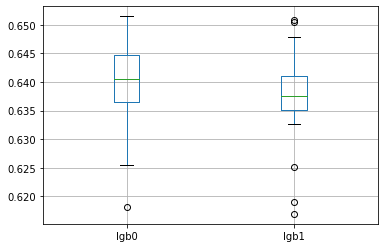

In [129]:
score_df2 = pd.DataFrame()
for key, value in score_log.items():
    score_df2[key] = pd.DataFrame(value)
score_df2["fold"] = pd.DataFrame(range(1,21))
score_df2.set_index("fold", inplace=True)
score_df2.boxplot()

#### Combinaison des modèles

In [137]:
## Combinaison par stacking
from sklearn.ensemble import StackingClassifier

model_log1, model_log = (LogisticRegression(),)*2
model_lgb1, model_lgb = (lgb.LGBMClassifier(),)*2
estimators = [("lgbm",model_lgb1),("logistic", model_log1)]
stacking = StackingClassifier(estimators = estimators)

In [138]:
## Training stacking classifier
score_log = {}
score_log["log"] = []
score_log["lgb"] = []
score_log["stack"] = []
compt = 1
for train, test in folds:
    print(f"{compt} debut")

    target_train, target_test = target.iloc[train], target.iloc[test]
    features_train, features_test = features.iloc[train], features.iloc[test]

    features_train, target_train = smote.fit_resample(features_train, target_train)
    
    model_log.fit(features_train, target_train)
    print("log fin")
    model_lgb.fit(features_train, target_train)
    print("lgb fin")
    stacking.fit(features_train, target_train)
    print("stack fin")
    
    forecast_log1 = model_log.predict(features_test,)
    forecast_log2 = model_lgb.predict(features_test,)
    forecast_log3 = stacking.predict(features_test,)
    score_log["log"].append(f1_score(target_test, forecast_log1))
    score_log["lgb"].append(f1_score(target_test, forecast_log2))
    score_log["stack"].append(f1_score(target_test, forecast_log3))
    compt += 1
    print(f"{compt} fin")


1 debut
log fin
lgb fin
stack fin
2 fin
2 debut
log fin
lgb fin
stack fin
3 fin
3 debut
log fin
lgb fin
stack fin
4 fin
4 debut
log fin
lgb fin
stack fin
5 fin
5 debut
log fin
lgb fin
stack fin
6 fin
6 debut
log fin
lgb fin
stack fin
7 fin
7 debut
log fin
lgb fin
stack fin
8 fin
8 debut
log fin
lgb fin
stack fin
9 fin
9 debut
log fin
lgb fin
stack fin
10 fin
10 debut
log fin
lgb fin
stack fin
11 fin
11 debut
log fin
lgb fin
stack fin
12 fin
12 debut
log fin
lgb fin
stack fin
13 fin
13 debut
log fin
lgb fin
stack fin
14 fin
14 debut
log fin
lgb fin
stack fin
15 fin
15 debut
log fin
lgb fin
stack fin
16 fin
16 debut
log fin
lgb fin
stack fin
17 fin
17 debut
log fin
lgb fin
stack fin
18 fin
18 debut
log fin
lgb fin
stack fin
19 fin
19 debut
log fin
lgb fin
stack fin
20 fin
20 debut
log fin
lgb fin
stack fin
21 fin


<AxesSubplot:>

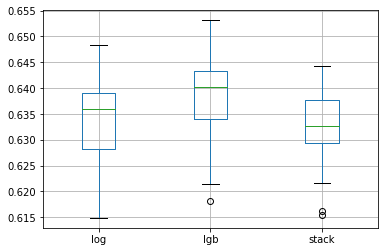

In [139]:
score_df2 = pd.DataFrame()
for key, value in score_log.items():
    score_df2[key] = pd.DataFrame(value)
score_df2["fold"] = pd.DataFrame(range(1,21))
score_df2.set_index("fold", inplace=True)
score_df2.boxplot()

#### Compréhension du modèle choisi

In [16]:
## Pour la suite, nous choisissons le modèle
## de Light Gradient Boosting auquel nous appliquerons
## les méthodes agnostic afin de mieux comprendre son
## fonctionnement
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(x_train, y_train)

LGBMClassifier()

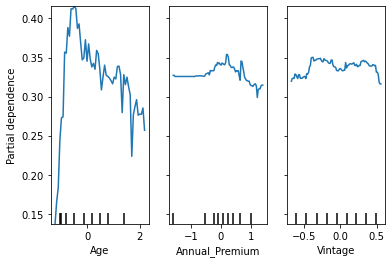

In [17]:
## Partial dependent plot pour les trois variables
## les plus importante dans le modèle lightGBM
from sklearn.inspection import PartialDependenceDisplay
features = ("Age", "Annual_Premium", "Vintage")
PartialDependenceDisplay.from_estimator(model_lgb, x_test, features)

In [18]:
import shap

explainer = shap.Explainer(model_lgb.predict, x_test)
shap_value = explainer(x_test)
shap_values = explainer.shap_values(x_test)

Permutation explainer: 5251it [15:46,  5.51it/s]                          
Permutation explainer: 5251it [08:01, 10.61it/s]                          


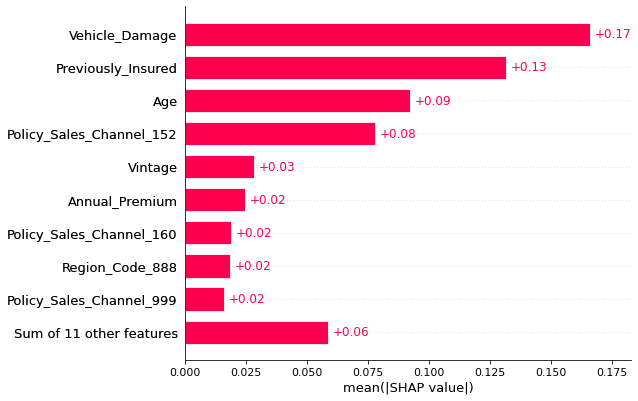

In [21]:
shap.plots.bar(shap_value)

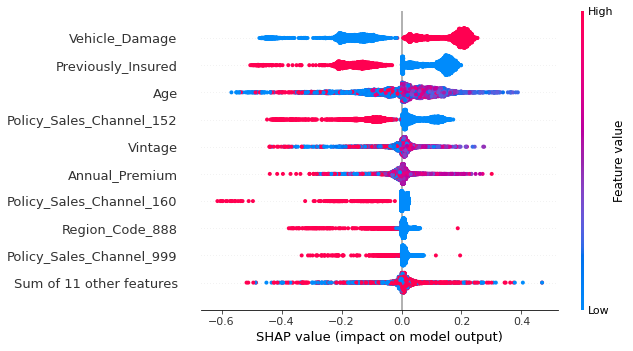

In [22]:
shap.plots.beeswarm(shap_value)

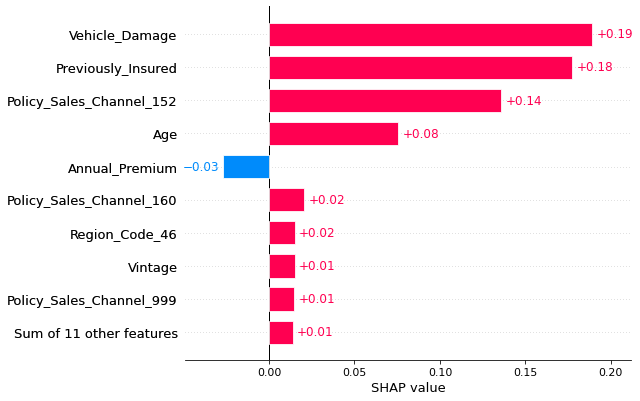

In [23]:
shap.plots.bar(shap_value[0])

### Entrainement final du modèle

In [24]:
smote = SMOTE()
df = preprocessing_df(train_set)
x_train = df.drop("Response", axis=1)
y_train = df["Response"]
x_train, y_train = smote.fit_resample(x_train, y_train)

In [25]:
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(x_train, y_train)

LGBMClassifier()

In [26]:
import joblib
path = "./model_lgb.sav"
joblib.dump(model_lgb, path)

['./model_lgb.sav']